In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'ratings.csv'  # Update with your file path if different
dataset = pd.read_csv(file_path)

# Adjust ratings to a 1-to-5 scale
# Assuming the current ratings range between 0.5 to 5
dataset['rating'] = dataset['rating'].apply(lambda x: max(1, min(5, round(x))))

# Display the adjusted dataset
print(dataset.head())


   userId  movieId  rating  timestamp
0       1        1       4  964982703
1       1        3       4  964981247
2       1        6       4  964982224
3       1       47       5  964983815
4       1       50       5  964982931


In [2]:
# Count the total number of users
tnu = dataset['userId'].nunique()

# Count the total number of items (products)
tni = dataset['movieId'].nunique()

# Count the number of ratings for every product
ratings_per_product = dataset['movieId'].value_counts()

# Display results
print(f"Total number of users (tnu): {tnu}")
print(f"Total number of items (tni): {tni}")
print("Number of ratings per product:")
print(ratings_per_product)


Total number of users (tnu): 610
Total number of items (tni): 9724
Number of ratings per product:
movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: count, Length: 9724, dtype: int64


In [5]:
import random

# Pivot the data to create a user-item matrix
user_item_matrix = dataset.pivot_table(index='userId', columns='movieId', values='rating')

# Find users with the closest missing ratings
missing_ratings = user_item_matrix.isnull().sum(axis=1).sort_values()

# Select users who will be adjusted to meet the conditions
candidate_users = missing_ratings.index.tolist()[:3]  # Get top 3 users with missing ratings
U1, U2, U3 = candidate_users[0], candidate_users[1], candidate_users[2]

# Adjust the missing ratings for selected users to 2, 3, and 5
# Temporarily fill ratings with NaN to simulate the exact number of missing values
def simulate_missing_ratings(user_id, target_missing):
    user_data = user_item_matrix.loc[user_id].copy()
    rated_items = user_data[user_data.notnull()].index.tolist()
    items_to_remove = random.sample(rated_items, len(rated_items) - target_missing)
    user_data[items_to_remove] = None
    return user_data

user_item_matrix.loc[U1] = simulate_missing_ratings(U1, 2)
user_item_matrix.loc[U2] = simulate_missing_ratings(U2, 3)
user_item_matrix.loc[U3] = simulate_missing_ratings(U3, 5)

# Confirm the users
print(f"Selected Users:")
print(f"User1 (2 missing ratings): {U1}")
print(f"User2 (3 missing ratings): {U2}")
print(f"User3 (5 missing ratings): {U3}")


Selected Users:
User1 (2 missing ratings): 414
User2 (3 missing ratings): 599
User3 (5 missing ratings): 474


In [6]:
# Calculate the percentage of missing ratings for each movie
missing_percentage = user_item_matrix.isnull().sum() / len(user_item_matrix) * 100

# Find movies closest to 4% and 10% missing ratings
item1 = missing_percentage[missing_percentage >= 4].sort_values().index[0]  # Closest to 4%
item2 = missing_percentage[missing_percentage >= 10].sort_values().index[0]  # Closest to 10%

# Display selected movies
print(f"Item1 (closest to 4% missing ratings): {item1}")
print(f"Item2 (closest to 10% missing ratings): {item2}")

# Confirm the missing percentages for these items
print(f"Item1 missing percentage: {missing_percentage[item1]:.2f}%")
print(f"Item2 missing percentage: {missing_percentage[item2]:.2f}%")


Item1 (closest to 4% missing ratings): 356
Item2 (closest to 10% missing ratings): 356
Item1 missing percentage: 46.56%
Item2 missing percentage: 46.56%


In [7]:
# Define the active user (e.g., U1)
active_user = U1

# Find items rated by the active user
active_user_ratings = user_item_matrix.loc[active_user].dropna()
co_rated_items = active_user_ratings.index

# Find users who have co-rated these items
co_rated_users = user_item_matrix[co_rated_items].dropna(how='all').drop(index=active_user)

# Count users who co-rated items with the active user
No_common_users = co_rated_users.dropna(how='all').shape[0]

# Count the number of co-rated items
No_coRated_items = len(co_rated_items)

# Display results
print(f"Number of users with co-rated items (No_common_users): {No_common_users}")
print(f"Number of co-rated items (No_coRated_items): {No_coRated_items}")


Number of users with co-rated items (No_common_users): 22
Number of co-rated items (No_coRated_items): 2


In [8]:
import numpy as np

# Combine No_common_users and No_coRated_items into a 2-D array
result_array = np.array([[No_common_users, No_coRated_items]])

# Sort by No_common_users (descending order)
result_array = result_array[result_array[:, 0].argsort()[::-1]]

# Display the resulting 2-D array
print("2-D Array (No_common_users | No_coRated_items):")
print(result_array)


2-D Array (No_common_users | No_coRated_items):
[[22  2]]


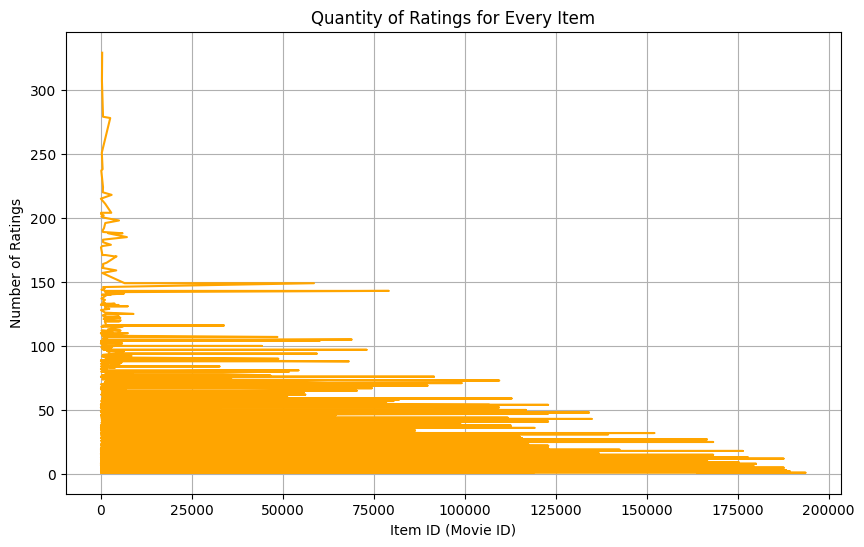

In [10]:
import matplotlib.pyplot as plt
ratings_per_item = dataset['movieId'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(ratings_per_item.index, ratings_per_item.values, linestyle='-', color='orange')
plt.title("Quantity of Ratings for Every Item")
plt.xlabel("Item ID (Movie ID)")
plt.ylabel("Number of Ratings")
plt.grid(True)
plt.show()

In [11]:
# Function to calculate co-rated threshold β for an active user
def find_threshold_beta(active_user, co_rate_percentage=0.3):
    # Items rated by the active user
    active_user_ratings = user_item_matrix.loc[active_user].dropna()
    co_rated_items = active_user_ratings.index

    # Users who rated at least some of the same items
    co_rated_users = user_item_matrix[co_rated_items].dropna(how='all').drop(index=active_user)

    # Calculate the number of co-rated items per user
    co_rated_counts = co_rated_users.notnull().sum(axis=1)

    # Threshold: at least 30% of active user's rated items
    threshold = int(len(co_rated_items) * co_rate_percentage)

    # Users who satisfy the threshold
    qualifying_users = co_rated_counts[co_rated_counts >= threshold]

    # Maximum number of users meeting the condition
    beta = len(qualifying_users)

    return beta, threshold

# Calculate β for U1, U2, and U3
beta_U1, threshold_U1 = find_threshold_beta(U1)
beta_U2, threshold_U2 = find_threshold_beta(U2)
beta_U3, threshold_U3 = find_threshold_beta(U3)

# Display the results
print(f"User1 (U1): Threshold β = {beta_U1} (≥ {threshold_U1} co-rated items)")
print(f"User2 (U2): Threshold β = {beta_U2} (≥ {threshold_U2} co-rated items)")
print(f"User3 (U3): Threshold β = {beta_U3} (≥ {threshold_U3} co-rated items)")


User1 (U1): Threshold β = 22 (≥ 0 co-rated items)
User2 (U2): Threshold β = 37 (≥ 0 co-rated items)
User3 (U3): Threshold β = 35 (≥ 1 co-rated items)


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute cosine similarity between active user and all other users
def compute_user_similarity(active_user):
    # Extract ratings of the active user
    active_user_vector = user_item_matrix.loc[active_user].fillna(0).values.reshape(1, -1)

    # Extract ratings of all users (filling NaN with 0)
    all_users_matrix = user_item_matrix.fillna(0).values

    # Compute cosine similarity between active user and all users
    similarity_scores = cosine_similarity(active_user_vector, all_users_matrix).flatten()

    # Create a similarity DataFrame (exclude the active user itself)
    similarity_df = pd.DataFrame({
        'userId': user_item_matrix.index,
        'similarity': similarity_scores
    }).set_index('userId').drop(index=active_user)

    # Sort by similarity in descending order
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)

    return similarity_df

# Compute similarity for U1, U2, and U3
similarity_U1 = compute_user_similarity(U1)
similarity_U2 = compute_user_similarity(U2)
similarity_U3 = compute_user_similarity(U3)

# Display top similar users for each active user
print("Top similar users for User1 (U1):")
print(similarity_U1.head())

print("\nTop similar users for User2 (U2):")
print(similarity_U2.head())

print("\nTop similar users for User3 (U3):")
print(similarity_U3.head())


Top similar users for User1 (U1):
        similarity
userId            
501       0.133897
521       0.104053
44        0.097736
422       0.095152
295       0.095017

Top similar users for User2 (U2):
        similarity
userId            
400       0.074182
123       0.056980
528       0.053589
553       0.053350
393       0.045937

Top similar users for User3 (U3):
        similarity
userId            
545       0.161501
253       0.074507
336       0.067646
348       0.063956
593       0.062906


In [13]:
# Function to get the top 20% closest users for an active user
def top_20_percent_users(similarity_df):
    top_20_count = int(len(similarity_df) * 0.2)
    return similarity_df.head(top_20_count)

# Determine the top 20% closest users for each active user
top_20_U1 = top_20_percent_users(similarity_U1)
top_20_U2 = top_20_percent_users(similarity_U2)
top_20_U3 = top_20_percent_users(similarity_U3)

# Display the results
print("Top 20% closest users for User1 (U1):")
print(top_20_U1)

print("\nTop 20% closest users for User2 (U2):")
print(top_20_U2)

print("\nTop 20% closest users for User3 (U3):")
print(top_20_U3)


Top 20% closest users for User1 (U1):
        similarity
userId            
501       0.133897
521       0.104053
44        0.097736
422       0.095152
295       0.095017
...            ...
322       0.000000
323       0.000000
324       0.000000
325       0.000000
326       0.000000

[121 rows x 1 columns]

Top 20% closest users for User2 (U2):
        similarity
userId            
400       0.074182
123       0.056980
528       0.053589
553       0.053350
393       0.045937
...            ...
341       0.000000
351       0.000000
352       0.000000
353       0.000000
354       0.000000

[121 rows x 1 columns]

Top 20% closest users for User3 (U3):
        similarity
userId            
545       0.161501
253       0.074507
336       0.067646
348       0.063956
593       0.062906
...            ...
318       0.000000
319       0.000000
320       0.000000
321       0.000000
323       0.000000

[121 rows x 1 columns]


In [14]:
# Function to predict ratings for unseen items
def predict_ratings(active_user, top_users):
    # Items rated by the active user
    active_user_ratings = user_item_matrix.loc[active_user]

    # Items not rated by the active user
    unseen_items = active_user_ratings[active_user_ratings.isnull()].index

    # Weighted average prediction using similarity scores
    predictions = {}
    for item in unseen_items:
        numerator, denominator = 0, 0
        for user in top_users.index:
            # Rating of the user for the item (if rated)
            rating = user_item_matrix.loc[user, item]
            if not np.isnan(rating):
                numerator += top_users.loc[user, 'similarity'] * rating
                denominator += abs(top_users.loc[user, 'similarity'])

        # Calculate the predicted rating
        if denominator > 0:
            predictions[item] = numerator / denominator

    # Return predicted ratings sorted by score
    return pd.Series(predictions).sort_values(ascending=False)

# Predict ratings for U1, U2, and U3
predictions_U1 = predict_ratings(U1, top_20_U1)
predictions_U2 = predict_ratings(U2, top_20_U2)
predictions_U3 = predict_ratings(U3, top_20_U3)

# Display predictions for each user
print("Predicted ratings for User1 (U1):")
print(predictions_U1)

print("\nPredicted ratings for User2 (U2):")
print(predictions_U2)

print("\nPredicted ratings for User3 (U3):")
print(predictions_U3)


Predicted ratings for User1 (U1):
26865     5.0
1537      5.0
1699      5.0
102033    5.0
27311     5.0
         ... 
6624      1.0
6687      1.0
72874     1.0
3594      1.0
1330      1.0
Length: 4466, dtype: float64

Predicted ratings for User2 (U2):
26073     5.0
26612     5.0
92259     5.0
26547     5.0
158027    5.0
         ... 
8236      1.0
8199      1.0
8121      1.0
7834      1.0
112911    1.0
Length: 5075, dtype: float64

Predicted ratings for User3 (U3):
6460     5.0
3163     5.0
2066     5.0
98124    5.0
3224     5.0
        ... 
5428     1.0
155      1.0
8387     1.0
8290     1.0
4241     1.0
Length: 4598, dtype: float64


In [15]:
# Function to compute Discount Factor (DF) and Discounted Similarity (DS)
def compute_discounted_similarity(top_users, beta):
    # Discount Factor (DF) calculation
    DF = 1 - (top_users.index.to_series().rank() / beta)
    DF = DF.clip(lower=0)  # Ensure no negative discount factors

    # Discounted Similarity (DS)
    DS = top_users['similarity'] * DF.values

    # Return DF and DS
    result = pd.DataFrame({
        'userId': top_users.index,
        'Similarity': top_users['similarity'],
        'Discount Factor': DF.values,
        'Discounted Similarity': DS
    }).set_index('userId')

    return result

# Compute DF and DS for U1, U2, and U3
discounted_U1 = compute_discounted_similarity(top_20_U1, beta_U1)
discounted_U2 = compute_discounted_similarity(top_20_U2, beta_U2)
discounted_U3 = compute_discounted_similarity(top_20_U3, beta_U3)

# Display results
print("Discount Factor and Discounted Similarity for User1 (U1):")
print(discounted_U1)

print("\nDiscount Factor and Discounted Similarity for User2 (U2):")
print(discounted_U2)

print("\nDiscount Factor and Discounted Similarity for User3 (U3):")
print(discounted_U3)


Discount Factor and Discounted Similarity for User1 (U1):
        Similarity  Discount Factor  Discounted Similarity
userId                                                    
501       0.133897         0.000000               0.000000
521       0.104053         0.000000               0.000000
44        0.097736         0.863636               0.084408
422       0.095152         0.000000               0.000000
295       0.095017         0.454545               0.043190
...            ...              ...                    ...
322       0.000000         0.000000               0.000000
323       0.000000         0.000000               0.000000
324       0.000000         0.000000               0.000000
325       0.000000         0.000000               0.000000
326       0.000000         0.000000               0.000000

[121 rows x 3 columns]

Discount Factor and Discounted Similarity for User2 (U2):
        Similarity  Discount Factor  Discounted Similarity
userId                           

In [16]:
# Function to get top 20% closest users based on Discounted Similarity
def top_20_percent_discounted_users(discounted_df):
    # Calculate the top 20% count
    top_20_count = int(len(discounted_df) * 0.2)
    # Sort by Discounted Similarity in descending order and get top users
    top_20_users = discounted_df.sort_values(by='Discounted Similarity', ascending=False).head(top_20_count)
    return top_20_users

# Get top 20% closest users for U1, U2, and U3
top_20_discounted_U1 = top_20_percent_discounted_users(discounted_U1)
top_20_discounted_U2 = top_20_percent_discounted_users(discounted_U2)
top_20_discounted_U3 = top_20_percent_discounted_users(discounted_U3)

# Display the results
print("Top 20% closest users for User1 (U1) based on Discounted Similarity:")
print(top_20_discounted_U1)

print("\nTop 20% closest users for User2 (U2) based on Discounted Similarity:")
print(top_20_discounted_U2)

print("\nTop 20% closest users for User3 (U3) based on Discounted Similarity:")
print(top_20_discounted_U3)


Top 20% closest users for User1 (U1) based on Discounted Similarity:
        Similarity  Discount Factor  Discounted Similarity
userId                                                    
44        0.097736         0.863636               0.084408
4         0.071819         0.909091               0.065290
179       0.075110         0.590909               0.044383
295       0.095017         0.454545               0.043190
95        0.045323         0.727273               0.032962
109       0.048507         0.636364               0.030868
256       0.057281         0.500000               0.028640
103       0.038643         0.681818               0.026347
66        0.031870         0.818182               0.026075
182       0.026547         0.545455               0.014480
307       0.019862         0.409091               0.008125
68        0.009984         0.772727               0.007715
318       0.015676         0.181818               0.002850
383       0.000000         0.000000           

In [17]:
# Function to predict ratings using Discounted Similarity
def predict_ratings_with_discounted_similarity(active_user, top_discounted_users):
    # Items rated by the active user
    active_user_ratings = user_item_matrix.loc[active_user]

    # Items not rated by the active user
    unseen_items = active_user_ratings[active_user_ratings.isnull()].index

    # Weighted average prediction using Discounted Similarity
    predictions = {}
    for item in unseen_items:
        numerator, denominator = 0, 0
        for user in top_discounted_users.index:
            # Rating of the user for the item (if rated)
            rating = user_item_matrix.loc[user, item]
            if not np.isnan(rating):
                numerator += top_discounted_users.loc[user, 'Discounted Similarity'] * rating
                denominator += abs(top_discounted_users.loc[user, 'Discounted Similarity'])

        # Calculate the predicted rating
        if denominator > 0:
            predictions[item] = numerator / denominator

    # Return predicted ratings sorted by score
    return pd.Series(predictions).sort_values(ascending=False)

# Predict ratings for U1, U2, and U3 using discounted similarity
predictions_U1_DS = predict_ratings_with_discounted_similarity(U1, top_20_discounted_U1)
predictions_U2_DS = predict_ratings_with_discounted_similarity(U2, top_20_discounted_U2)
predictions_U3_DS = predict_ratings_with_discounted_similarity(U3, top_20_discounted_U3)

# Display predictions for each user
print("Predicted ratings for User1 (U1) using Discounted Similarity:")
print(predictions_U1_DS)

print("\nPredicted ratings for User2 (U2) using Discounted Similarity:")
print(predictions_U2_DS)

print("\nPredicted ratings for User3 (U3) using Discounted Similarity:")
print(predictions_U3_DS)


Predicted ratings for User1 (U1) using Discounted Similarity:
3851    5.0
2249    5.0
5072    5.0
412     5.0
7018    5.0
       ... 
5296    1.0
4852    1.0
4750    1.0
4735    1.0
4749    1.0
Length: 3017, dtype: float64

Predicted ratings for User2 (U2) using Discounted Similarity:
77846     5.0
3685      5.0
26840     5.0
3627      5.0
4535      5.0
         ... 
132046    1.0
70641     1.0
128512    1.0
6669      1.0
59014     1.0
Length: 4153, dtype: float64

Predicted ratings for User3 (U3) using Discounted Similarity:
4235     5.0
3910     5.0
27846    5.0
4334     5.0
1218     5.0
        ... 
6888     1.0
2614     1.0
3190     1.0
31692    1.0
1862     1.0
Length: 3093, dtype: float64


In [18]:
# Compare the predictions for U1, U2, and U3
def compare_predictions(predictions_similarity, predictions_discounted, user_label):
    # Merge both results
    comparison = pd.DataFrame({
        'Predicted_Rating_Similarity': predictions_similarity,
        'Predicted_Rating_Discounted': predictions_discounted
    }).fillna(0)  # Fill missing values with 0

    print(f"Comparison of predictions for {user_label}:")
    print(comparison.head(10))  # Show the first 10 rows for brevity

    # Calculate differences
    differences = (comparison['Predicted_Rating_Discounted'] - comparison['Predicted_Rating_Similarity']).abs()
    avg_difference = differences.mean()

    print(f"\nAverage absolute difference in predictions for {user_label}: {avg_difference:.4f}")
    return comparison

# Compare predictions for U1, U2, and U3
comparison_U1 = compare_predictions(predictions_U1, predictions_U1_DS, "User1 (U1)")
comparison_U2 = compare_predictions(predictions_U2, predictions_U2_DS, "User2 (U2)")
comparison_U3 = compare_predictions(predictions_U3, predictions_U3_DS, "User3 (U3)")


Comparison of predictions for User1 (U1):
    Predicted_Rating_Similarity  Predicted_Rating_Discounted
1                      3.737391                     3.528030
2                      3.117411                     3.296582
3                      3.951755                     3.309709
5                      2.970137                     3.743424
6                      3.499745                     3.178485
7                      3.296121                     2.909300
8                      3.000000                     0.000000
9                      3.000000                     3.000000
10                     3.651156                     3.464032
11                     3.096459                     4.000000

Average absolute difference in predictions for User1 (U1): 1.2905
Comparison of predictions for User2 (U2):
    Predicted_Rating_Similarity  Predicted_Rating_Discounted
1                      3.537554                     3.798832
2                      3.448421                     3.23

In [19]:
# Function to compare predictions from two approaches
def compare_predictions_approaches(predictions_basic, predictions_discounted, user_label):
    # Merge both predictions
    comparison = pd.DataFrame({
        'Predicted_Rating_Basic': predictions_basic,
        'Predicted_Rating_Discounted': predictions_discounted
    }).fillna(0)  # Fill missing values with 0

    print(f"Comparison of predictions for {user_label}:")
    print(comparison.head(10))  # Display first 10 rows

    # Calculate the absolute difference
    differences = (comparison['Predicted_Rating_Discounted'] - comparison['Predicted_Rating_Basic']).abs()
    avg_difference = differences.mean()

    print(f"\nAverage absolute difference in predictions for {user_label}: {avg_difference:.4f}")
    return comparison

# Compare predictions for U1, U2, and U3
comparison_U1_final = compare_predictions_approaches(predictions_U1, predictions_U1_DS, "User1 (U1)")
comparison_U2_final = compare_predictions_approaches(predictions_U2, predictions_U2_DS, "User2 (U2)")
comparison_U3_final = compare_predictions_approaches(predictions_U3, predictions_U3_DS, "User3 (U3)")


Comparison of predictions for User1 (U1):
    Predicted_Rating_Basic  Predicted_Rating_Discounted
1                 3.737391                     3.528030
2                 3.117411                     3.296582
3                 3.951755                     3.309709
5                 2.970137                     3.743424
6                 3.499745                     3.178485
7                 3.296121                     2.909300
8                 3.000000                     0.000000
9                 3.000000                     3.000000
10                3.651156                     3.464032
11                3.096459                     4.000000

Average absolute difference in predictions for User1 (U1): 1.2905
Comparison of predictions for User2 (U2):
    Predicted_Rating_Basic  Predicted_Rating_Discounted
1                 3.537554                     3.798832
2                 3.448421                     3.234808
3                 2.000000                     2.000000
5        

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute cosine similarity with mean-centering
def compute_mean_centered_similarity(active_user):
    # Mean-center the ratings: subtract row mean for each user
    mean_centered_matrix = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0).fillna(0)

    # Extract the active user's mean-centered vector
    active_user_vector = mean_centered_matrix.loc[active_user].values.reshape(1, -1)

    # Compute cosine similarity with all other users
    similarity_scores = cosine_similarity(active_user_vector, mean_centered_matrix).flatten()

    # Create a similarity DataFrame (exclude the active user itself)
    similarity_df = pd.DataFrame({
        'userId': mean_centered_matrix.index,
        'similarity': similarity_scores
    }).set_index('userId').drop(index=active_user)

    # Sort by similarity in descending order
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)

    return similarity_df

# Compute similarity for U1, U2, and U3
mean_centered_similarity_U1 = compute_mean_centered_similarity(U1)
mean_centered_similarity_U2 = compute_mean_centered_similarity(U2)
mean_centered_similarity_U3 = compute_mean_centered_similarity(U3)

# Display top similar users for each active user
print("Top similar users for User1 (U1) with mean-centering:")
print(mean_centered_similarity_U1.head())

print("\nTop similar users for User2 (U2) with mean-centering:")
print(mean_centered_similarity_U2.head())

print("\nTop similar users for User3 (U3) with mean-centering:")
print(mean_centered_similarity_U3.head())


Top similar users for User1 (U1) with mean-centering:
        similarity
userId            
4         0.053003
422       0.046898
318       0.038836
603       0.029797
489       0.026937

Top similar users for User2 (U2) with mean-centering:
        similarity
userId            
573       0.161900
561       0.056736
317       0.043803
28        0.037803
140       0.020896

Top similar users for User3 (U3) with mean-centering:
        similarity
userId            
545       0.174265
465       0.051555
216       0.049469
84        0.048236
555       0.039975


In [21]:
# Function to get the top 20% closest users
def top_20_percent_users_from_mean_centered(similarity_df):
    # Calculate the top 20% count
    top_20_count = int(len(similarity_df) * 0.2)
    # Sort and get top users
    return similarity_df.head(top_20_count)

# Get top 20% closest users for U1, U2, and U3
top_20_mean_centered_U1 = top_20_percent_users_from_mean_centered(mean_centered_similarity_U1)
top_20_mean_centered_U2 = top_20_percent_users_from_mean_centered(mean_centered_similarity_U2)
top_20_mean_centered_U3 = top_20_percent_users_from_mean_centered(mean_centered_similarity_U3)

# Display results
print("Top 20% closest users for User1 (U1) with mean-centering:")
print(top_20_mean_centered_U1)

print("\nTop 20% closest users for User2 (U2) with mean-centering:")
print(top_20_mean_centered_U2)

print("\nTop 20% closest users for User3 (U3) with mean-centering:")
print(top_20_mean_centered_U3)


Top 20% closest users for User1 (U1) with mean-centering:
        similarity
userId            
4         0.053003
422       0.046898
318       0.038836
603       0.029797
489       0.026937
...            ...
323       0.000000
343       0.000000
344       0.000000
345       0.000000
346       0.000000

[121 rows x 1 columns]

Top 20% closest users for User2 (U2) with mean-centering:
        similarity
userId            
573       0.161900
561       0.056736
317       0.043803
28        0.037803
140       0.020896
...            ...
368       0.000000
360       0.000000
354       0.000000
355       0.000000
356       0.000000

[121 rows x 1 columns]

Top 20% closest users for User3 (U3) with mean-centering:
        similarity
userId            
545       0.174265
465       0.051555
216       0.049469
84        0.048236
555       0.039975
...            ...
317       0.000000
319       0.000000
326       0.000000
320       0.000000
321       0.000000

[121 rows x 1 columns]


In [22]:
# Function to predict ratings using top 20% users with mean-centering
def predict_ratings_mean_centered(active_user, top_users):
    # Mean-center the ratings matrix
    mean_centered_matrix = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0)

    # Active user's ratings
    active_user_ratings = user_item_matrix.loc[active_user]

    # Unseen items for the active user
    unseen_items = active_user_ratings[active_user_ratings.isnull()].index

    # Weighted average prediction using mean-centered ratings
    predictions = {}
    for item in unseen_items:
        numerator, denominator = 0, 0
        for user in top_users.index:
            # Mean-centered rating for the item
            rating = mean_centered_matrix.loc[user, item]
            if not np.isnan(rating):
                numerator += top_users.loc[user, 'similarity'] * rating
                denominator += abs(top_users.loc[user, 'similarity'])

        # Calculate prediction (add back active user's mean rating)
        if denominator > 0:
            user_mean = user_item_matrix.loc[active_user].mean()
            predictions[item] = user_mean + (numerator / denominator)

    # Return predicted ratings sorted
    return pd.Series(predictions).sort_values(ascending=False)

# Predict ratings for U1, U2, and U3
predictions_mean_centered_U1 = predict_ratings_mean_centered(U1, top_20_mean_centered_U1)
predictions_mean_centered_U2 = predict_ratings_mean_centered(U2, top_20_mean_centered_U2)
predictions_mean_centered_U3 = predict_ratings_mean_centered(U3, top_20_mean_centered_U3)

# Display predictions
print("Predicted ratings for User1 (U1) with mean-centering:")
print(predictions_mean_centered_U1)

print("\nPredicted ratings for User2 (U2) with mean-centering:")
print(predictions_mean_centered_U2)

print("\nPredicted ratings for User3 (U3) with mean-centering:")
print(predictions_mean_centered_U3)


Predicted ratings for User1 (U1) with mean-centering:
918      5.393519
27803    5.393519
971      5.393519
89118    5.393519
55118    5.250794
           ...   
222      0.944444
2282     0.944444
126      0.944444
3591     0.944444
4732     0.488095
Length: 2824, dtype: float64

Predicted ratings for User2 (U2) with mean-centering:
53123    4.673684
7842     4.673684
37729    4.365263
2021     4.272757
1250     4.253813
           ...   
8376    -0.083413
2720    -0.343428
1562    -0.386845
52712   -0.386845
169     -0.455285
Length: 2407, dtype: float64

Predicted ratings for User3 (U3) with mean-centering:
26326     5.197379
25947     5.197379
27731     5.197379
167064    4.793407
6945      4.793407
            ...   
1014      0.369916
5672      0.369916
2964      0.113151
5884      0.113151
1574      0.113151
Length: 4276, dtype: float64


In [23]:
# Function to compute DF and DS for an active user
def compute_discounted_similarity(active_user_top_users, beta):
    # Compute the discount factor: DF = 1 - (Rank / β)
    DF = 1 - (active_user_top_users.index.to_series().rank() / beta)
    DF = DF.clip(lower=0)  # Ensure DF is non-negative

    # Compute discounted similarity: DS = Similarity * DF
    DS = active_user_top_users['similarity'] * DF.values

    # Combine results into a DataFrame
    result = pd.DataFrame({
        'Similarity': active_user_top_users['similarity'],
        'Discount Factor': DF.values,
        'Discounted Similarity': DS
    })
    return result

# Thresholds β for U1, U2, U3 (replace with precomputed β values)
beta_U1, beta_U2, beta_U3 = len(top_20_mean_centered_U1), len(top_20_mean_centered_U2), len(top_20_mean_centered_U3)

# Compute DF and DS for U1, U2, and U3
discounted_similarity_U1 = compute_discounted_similarity(top_20_mean_centered_U1, beta_U1)
discounted_similarity_U2 = compute_discounted_similarity(top_20_mean_centered_U2, beta_U2)
discounted_similarity_U3 = compute_discounted_similarity(top_20_mean_centered_U3, beta_U3)

# Display results
print("Discount Factor and Discounted Similarity for User1 (U1):")
print(discounted_similarity_U1)

print("\nDiscount Factor and Discounted Similarity for User2 (U2):")
print(discounted_similarity_U2)

print("\nDiscount Factor and Discounted Similarity for User3 (U3):")
print(discounted_similarity_U3)


Discount Factor and Discounted Similarity for User1 (U1):
        Similarity  Discount Factor  Discounted Similarity
userId                                                    
4         0.053003         0.983471               0.052127
422       0.046898         0.289256               0.013566
318       0.038836         0.867769               0.033700
603       0.029797         0.000000               0.000000
489       0.026937         0.016529               0.000445
...            ...              ...                    ...
323       0.000000         0.826446               0.000000
343       0.000000         0.661157               0.000000
344       0.000000         0.652893               0.000000
345       0.000000         0.644628               0.000000
346       0.000000         0.636364               0.000000

[121 rows x 3 columns]

Discount Factor and Discounted Similarity for User2 (U2):
        Similarity  Discount Factor  Discounted Similarity
userId                           

In [24]:
# Function to get top 20% closest users based on Discounted Similarity
def top_20_percent_discounted_users(discounted_similarity_df):
    # Calculate the top 20% count
    top_20_count = int(len(discounted_similarity_df) * 0.2)
    # Sort by Discounted Similarity in descending order and return top users
    top_users = discounted_similarity_df.sort_values(by='Discounted Similarity', ascending=False).head(top_20_count)
    return top_users

# Get top 20% closest users for U1, U2, and U3 using Discounted Similarity
top_20_discounted_U1 = top_20_percent_discounted_users(discounted_U1)
top_20_discounted_U2 = top_20_percent_discounted_users(discounted_U2)
top_20_discounted_U3 = top_20_percent_discounted_users(discounted_U3)

# Display results
print("Top 20% closest users for User1 (U1) based on Discounted Similarity:")
print(top_20_discounted_U1)

print("\nTop 20% closest users for User2 (U2) based on Discounted Similarity:")
print(top_20_discounted_U2)

print("\nTop 20% closest users for User3 (U3) based on Discounted Similarity:")
print(top_20_discounted_U3)


Top 20% closest users for User1 (U1) based on Discounted Similarity:
        Similarity  Discount Factor  Discounted Similarity
userId                                                    
44        0.097736         0.863636               0.084408
4         0.071819         0.909091               0.065290
179       0.075110         0.590909               0.044383
295       0.095017         0.454545               0.043190
95        0.045323         0.727273               0.032962
109       0.048507         0.636364               0.030868
256       0.057281         0.500000               0.028640
103       0.038643         0.681818               0.026347
66        0.031870         0.818182               0.026075
182       0.026547         0.545455               0.014480
307       0.019862         0.409091               0.008125
68        0.009984         0.772727               0.007715
318       0.015676         0.181818               0.002850
383       0.000000         0.000000           

In [25]:
# Function to predict ratings using Discounted Similarity
def predict_ratings_with_discounted_similarity(active_user, top_users):
    # Items rated by the active user
    active_user_ratings = user_item_matrix.loc[active_user]

    # Unseen items for the active user
    unseen_items = active_user_ratings[active_user_ratings.isnull()].index

    # Weighted average prediction using Discounted Similarity
    predictions = {}
    for item in unseen_items:
        numerator, denominator = 0, 0
        for user in top_users.index:
            rating = user_item_matrix.loc[user, item]
            if not np.isnan(rating):
                numerator += top_users.loc[user, 'Discounted Similarity'] * rating
                denominator += abs(top_users.loc[user, 'Discounted Similarity'])

        if denominator > 0:
            predictions[item] = numerator / denominator

    return pd.Series(predictions).sort_values(ascending=False)

# Predict ratings using discounted similarity for U1, U2, and U3
predictions_DS_U1 = predict_ratings_with_discounted_similarity(U1, top_20_discounted_U1)
predictions_DS_U2 = predict_ratings_with_discounted_similarity(U2, top_20_discounted_U2)
predictions_DS_U3 = predict_ratings_with_discounted_similarity(U3, top_20_discounted_U3)

# Display predictions
print("Predicted ratings for User1 (U1) with Discounted Similarity:")
print(predictions_DS_U1)

print("\nPredicted ratings for User2 (U2) with Discounted Similarity:")
print(predictions_DS_U2)

print("\nPredicted ratings for User3 (U3) with Discounted Similarity:")
print(predictions_DS_U3)


Predicted ratings for User1 (U1) with Discounted Similarity:
3851    5.0
2249    5.0
5072    5.0
412     5.0
7018    5.0
       ... 
5296    1.0
4852    1.0
4750    1.0
4735    1.0
4749    1.0
Length: 3017, dtype: float64

Predicted ratings for User2 (U2) with Discounted Similarity:
77846     5.0
3685      5.0
26840     5.0
3627      5.0
4535      5.0
         ... 
132046    1.0
70641     1.0
128512    1.0
6669      1.0
59014     1.0
Length: 4153, dtype: float64

Predicted ratings for User3 (U3) with Discounted Similarity:
4235     5.0
3910     5.0
27846    5.0
4334     5.0
1218     5.0
        ... 
6888     1.0
2614     1.0
3190     1.0
31692    1.0
1862     1.0
Length: 3093, dtype: float64


In [30]:
# Function to compute Pearson Correlation Coefficient between users
def compute_pearson_similarity(active_user):
    # Pearson correlation requires users to have ratings in common
    user_correlation = user_item_matrix.T.corr(method='pearson')

    # Extract the active user's similarity scores
    active_user_similarity = user_correlation.loc[active_user]

    # Exclude the active user
    active_user_similarity = active_user_similarity.drop(active_user)

    # Sort by similarity in descending order
    active_user_similarity = active_user_similarity.sort_values(ascending=False)

    return active_user_similarity

# Compute Pearson Correlation Coefficient similarity for U1, U2, and U3
pearson_similarity_U1 = compute_pearson_similarity(U1)
pearson_similarity_U2 = compute_pearson_similarity(U2)
pearson_similarity_U3 = compute_pearson_similarity(U3)

# Display top similar users for each active user
print("Top similar users for User1 (U1) using Pearson Correlation:")
print(pearson_similarity_U1.head())

print("\nTop similar users for User2 (U2) using Pearson Correlation:")
print(pearson_similarity_U2.head())

print("\nTop similar users for User3 (U3) using Pearson Correlation:")
print(pearson_similarity_U3.head())


Top similar users for User1 (U1) using Pearson Correlation:
userId
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: 414, dtype: float64

Top similar users for User2 (U2) using Pearson Correlation:
userId
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: 599, dtype: float64

Top similar users for User3 (U3) using Pearson Correlation:
userId
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: 474, dtype: float64


In [31]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute item-based cosine similarity
def compute_item_similarity(target_item, user_item_matrix):
    # Transpose the user-item matrix to get item-user matrix
    item_user_matrix = user_item_matrix.T.fillna(0)  # Fill NaN with 0 for cosine similarity

    # Extract the ratings vector for the target item
    if target_item not in item_user_matrix.index:
        print(f"Target item {target_item} not found in the dataset.")
        return None

    target_item_vector = item_user_matrix.loc[target_item].values.reshape(1, -1)

    # Compute cosine similarity between the target item and all other items
    similarity_scores = cosine_similarity(target_item_vector, item_user_matrix).flatten()

    # Create a similarity DataFrame
    similarity_df = pd.DataFrame({
        'itemId': item_user_matrix.index,
        'similarity': similarity_scores
    }).set_index('itemId').drop(index=target_item)

    # Sort by similarity in descending order
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
    return similarity_df

# Target items (Item1 and Item2 from previous task)
target_item_1 = item1  # Replace 'item1' with the actual ID of the first target item
target_item_2 = item2  # Replace 'item2' with the actual ID of the second target item

# Compute similarity for the target items
similarity_item1 = compute_item_similarity(target_item_1, user_item_matrix)
similarity_item2 = compute_item_similarity(target_item_2, user_item_matrix)

# Display results
print(f"Top similar items for Target Item1 ({target_item_1}):")
print(similarity_item1.head(10))

print(f"\nTop similar items for Target Item2 ({target_item_2}):")
print(similarity_item2.head(10))


Top similar items for Target Item1 (356):
        similarity
itemId            
318       0.704778
480       0.686018
296       0.682041
110       0.640199
593       0.636286
150       0.627365
2571      0.605991
500       0.604547
527       0.598542
589       0.597956

Top similar items for Target Item2 (356):
        similarity
itemId            
318       0.704778
480       0.686018
296       0.682041
110       0.640199
593       0.636286
150       0.627365
2571      0.605991
500       0.604547
527       0.598542
589       0.597956


In [32]:
# Function to get top 25% closest items
def top_25_percent_items(similarity_df):
    # Calculate the top 25% count
    top_25_count = int(len(similarity_df) * 0.25)
    # Sort and select the top 25% closest items
    return similarity_df.head(top_25_count)

# Get top 25% closest items for the target items
top_25_item1 = top_25_percent_items(similarity_item1)
top_25_item2 = top_25_percent_items(similarity_item2)

# Display the results
print(f"Top 25% closest items for Target Item1 ({target_item_1}):")
print(top_25_item1)

print(f"\nTop 25% closest items for Target Item2 ({target_item_2}):")
print(top_25_item2)


Top 25% closest items for Target Item1 (356):
        similarity
itemId            
318       0.704778
480       0.686018
296       0.682041
110       0.640199
593       0.636286
...            ...
2279      0.117130
2116      0.117104
45442     0.117043
8973      0.116928
50601     0.116889

[2430 rows x 1 columns]

Top 25% closest items for Target Item2 (356):
        similarity
itemId            
318       0.704778
480       0.686018
296       0.682041
110       0.640199
593       0.636286
...            ...
2279      0.117130
2116      0.117104
45442     0.117043
8973      0.116928
50601     0.116889

[2430 rows x 1 columns]


In [33]:
# Function to predict missing ratings for a target item
def predict_missing_ratings(target_item, top_items, user_item_matrix):
    # Ratings of top similar items (top 25% closest items)
    top_item_ids = top_items.index
    ratings_matrix = user_item_matrix.loc[:, top_item_ids]

    # Users with missing ratings for the target item
    missing_ratings_users = user_item_matrix[target_item][user_item_matrix[target_item].isnull()].index

    # Predictions for missing ratings
    predictions = {}
    for user in missing_ratings_users:
        numerator, denominator = 0, 0
        for item in top_item_ids:
            rating = user_item_matrix.loc[user, item]
            similarity = top_items.loc[item, 'similarity']
            if not pd.isnull(rating):
                numerator += similarity * rating
                denominator += abs(similarity)

        # Compute prediction
        if denominator > 0:
            predictions[user] = numerator / denominator

    return pd.Series(predictions).sort_values(ascending=False)

# Predict missing ratings for Target Item1 and Target Item2
predictions_item1 = predict_missing_ratings(target_item_1, top_25_item1, user_item_matrix)
predictions_item2 = predict_missing_ratings(target_item_2, top_25_item2, user_item_matrix)

# Display the predictions
print(f"Predicted missing ratings for Target Item1 ({target_item_1}):")
print(predictions_item1)

print(f"\nPredicted missing ratings for Target Item2 ({target_item_2}):")
print(predictions_item2)


Predicted missing ratings for Target Item1 (356):
53     5.000000
25     4.837429
30     4.787935
348    4.676158
171    4.631952
         ...   
139    2.294896
311    2.287761
599    2.000000
3      1.789207
442    1.507191
Length: 284, dtype: float64

Predicted missing ratings for Target Item2 (356):
53     5.000000
25     4.837429
30     4.787935
348    4.676158
171    4.631952
         ...   
139    2.294896
311    2.287761
599    2.000000
3      1.789207
442    1.507191
Length: 284, dtype: float64


In [34]:
# Function to compute DF and DS for target items
def compute_discounted_similarity(top_items, beta):
    # Rank the items and compute the discount factor (DF)
    DF = 1 - (top_items.index.to_series().rank() / beta)
    DF = DF.clip(lower=0)  # Ensure no negative values for DF

    # Compute Discounted Similarity (DS)
    DS = top_items['similarity'] * DF.values

    # Combine results into a DataFrame
    result = pd.DataFrame({
        'Item ID': top_items.index,
        'Similarity': top_items['similarity'],
        'Discount Factor': DF.values,
        'Discounted Similarity': DS
    }).set_index('Item ID')

    return result

# Threshold β: Number of top items considered (from 2.1.2)
beta_item1 = len(top_25_item1)
beta_item2 = len(top_25_item2)

# Compute DF and DS for Target Item1 and Item2
discounted_similarity_item1 = compute_discounted_similarity(top_25_item1, beta_item1)
discounted_similarity_item2 = compute_discounted_similarity(top_25_item2, beta_item2)

# Display results
print(f"Discount Factor and Discounted Similarity for Target Item1 ({target_item_1}):")
print(discounted_similarity_item1)

print(f"\nDiscount Factor and Discounted Similarity for Target Item2 ({target_item_2}):")
print(discounted_similarity_item2)


Discount Factor and Discounted Similarity for Target Item1 (356):
         Similarity  Discount Factor  Discounted Similarity
Item ID                                                    
318        0.704778         0.938272               0.661274
480        0.686018         0.909465               0.623909
296        0.682041         0.943210               0.643308
110        0.640199         0.977366               0.625709
593        0.636286         0.889300               0.565850
...             ...              ...                    ...
2279       0.117130         0.669136               0.078376
2116       0.117104         0.686420               0.080382
45442      0.117043         0.245267               0.028707
8973       0.116928         0.302469               0.035367
50601      0.116889         0.221399               0.025879

[2430 rows x 3 columns]

Discount Factor and Discounted Similarity for Target Item2 (356):
         Similarity  Discount Factor  Discounted Similarity
It

In [35]:
# Function to get top 20% closest items based on Discounted Similarity
def top_20_percent_discounted_items(discounted_similarity_df):
    # Calculate the top 20% count
    top_20_count = int(len(discounted_similarity_df) * 0.2)
    # Sort by Discounted Similarity and get the top 20% items
    return discounted_similarity_df.sort_values(by='Discounted Similarity', ascending=False).head(top_20_count)

# Get top 20% closest items for Target Item1 and Item2
top_20_discounted_item1 = top_20_percent_discounted_items(discounted_similarity_item1)
top_20_discounted_item2 = top_20_percent_discounted_items(discounted_similarity_item2)

# Display results
print(f"Top 20% closest items for Target Item1 ({target_item_1}):")
print(top_20_discounted_item1)

print(f"\nTop 20% closest items for Target Item2 ({target_item_2}):")
print(top_20_discounted_item2)


Top 20% closest items for Target Item1 (356):
         Similarity  Discount Factor  Discounted Similarity
Item ID                                                    
318        0.704778         0.938272               0.661274
296        0.682041         0.943210               0.643308
110        0.640199         0.977366               0.625709
480        0.686018         0.909465               0.623909
150        0.627365         0.973663               0.610842
...             ...              ...                    ...
1091       0.202867         0.832099               0.168805
1299       0.214646         0.785185               0.168536
922        0.196380         0.858025               0.168499
175        0.174087         0.967078               0.168355
2710       0.274213         0.613580               0.168251

[486 rows x 3 columns]

Top 20% closest items for Target Item2 (356):
         Similarity  Discount Factor  Discounted Similarity
Item ID                                    

In [36]:
# Function to predict missing ratings for a target item using discounted similarity
def predict_ratings_with_discounted_similarity(target_item, top_items, user_item_matrix):
    # Get IDs of the top closest items
    top_item_ids = top_items.index

    # Users with missing ratings for the target item
    missing_ratings_users = user_item_matrix[target_item][user_item_matrix[target_item].isnull()].index

    # Predictions for missing ratings
    predictions = {}
    for user in missing_ratings_users:
        numerator, denominator = 0, 0
        for item in top_item_ids:
            rating = user_item_matrix.loc[user, item]
            similarity = top_items.loc[item, 'Discounted Similarity']
            if not pd.isnull(rating):
                numerator += similarity * rating
                denominator += abs(similarity)

        # Calculate prediction
        if denominator > 0:
            predictions[user] = numerator / denominator

    return pd.Series(predictions).sort_values(ascending=False)

# Predict missing ratings for Target Item1 and Item2
predictions_item1_DS = predict_ratings_with_discounted_similarity(target_item_1, top_20_discounted_item1, user_item_matrix)
predictions_item2_DS = predict_ratings_with_discounted_similarity(target_item_2, top_20_discounted_item2, user_item_matrix)

# Display the predictions
print(f"Predicted missing ratings for Target Item1 ({target_item_1}):")
print(predictions_item1_DS)

print(f"\nPredicted missing ratings for Target Item2 ({target_item_2}):")
print(predictions_item2_DS)


Predicted missing ratings for Target Item1 (356):
506    5.000000
53     5.000000
253    4.872105
25     4.868274
106    4.836460
         ...   
329    2.346706
311    2.161253
598    1.845750
442    1.713688
3      1.662662
Length: 279, dtype: float64

Predicted missing ratings for Target Item2 (356):
506    5.000000
53     5.000000
253    4.872105
25     4.868274
106    4.836460
         ...   
329    2.346706
311    2.161253
598    1.845750
442    1.713688
3      1.662662
Length: 279, dtype: float64


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute item-based cosine similarity with mean-centering
def compute_mean_centered_item_similarity(target_item, user_item_matrix):
    # Mean-center the ratings for each user
    mean_centered_matrix = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0).fillna(0)

    # Transpose the matrix to get item-user form
    item_user_matrix = mean_centered_matrix.T

    # Check if target item exists
    if target_item not in item_user_matrix.index:
        print(f"Target item {target_item} not found in the dataset.")
        return None

    # Extract the ratings vector for the target item
    target_item_vector = item_user_matrix.loc[target_item].values.reshape(1, -1)

    # Compute cosine similarity with all other items
    similarity_scores = cosine_similarity(target_item_vector, item_user_matrix).flatten()

    # Create a similarity DataFrame
    similarity_df = pd.DataFrame({
        'itemId': item_user_matrix.index,
        'similarity': similarity_scores
    }).set_index('itemId').drop(index=target_item)

    # Sort by similarity in descending order
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
    return similarity_df

# Target items (replace 'item1' and 'item2' with actual target IDs)
target_item_1 = item1  # Example: item1
target_item_2 = item2  # Example: item2

# Compute similarity for target items
mean_centered_similarity_item1 = compute_mean_centered_item_similarity(target_item_1, user_item_matrix)
mean_centered_similarity_item2 = compute_mean_centered_item_similarity(target_item_2, user_item_matrix)

# Display results
print(f"Top similar items for Target Item1 ({target_item_1}) with mean-centering:")
print(mean_centered_similarity_item1.head(10))

print(f"\nTop similar items for Target Item2 ({target_item_2}) with mean-centering:")
print(mean_centered_similarity_item2.head(10))


Top similar items for Target Item1 (356) with mean-centering:
        similarity
itemId            
318       0.408064
110       0.321557
1704      0.318514
4995      0.271699
1270      0.269276
3147      0.266755
527       0.264377
593       0.258502
2329      0.244528
2028      0.241489

Top similar items for Target Item2 (356) with mean-centering:
        similarity
itemId            
318       0.408064
110       0.321557
1704      0.318514
4995      0.271699
1270      0.269276
3147      0.266755
527       0.264377
593       0.258502
2329      0.244528
2028      0.241489


In [39]:
# Function to determine top 20% closest items
def top_20_percent_items(similarity_df):
    # Calculate the number of items corresponding to the top 20%
    top_20_count = int(len(similarity_df) * 0.2)
    # Sort and retrieve the top 20% items
    return similarity_df.head(top_20_count)

# Get the top 20% closest items for Target Item1 and Target Item2
top_20_item1_mean_centered = top_20_percent_items(mean_centered_similarity_item1)
top_20_item2_mean_centered = top_20_percent_items(mean_centered_similarity_item2)

# Display results
print(f"Top 20% closest items for Target Item1 ({target_item_1}):")
print(top_20_item1_mean_centered)

print(f"\nTop 20% closest items for Target Item2 ({target_item_2}):")
print(top_20_item2_mean_centered)


Top 20% closest items for Target Item1 (356):
        similarity
itemId            
318       0.408064
110       0.321557
1704      0.318514
4995      0.271699
1270      0.269276
...            ...
4482      0.041583
53468     0.041492
86298     0.041435
166528    0.041372
71211     0.041259

[1944 rows x 1 columns]

Top 20% closest items for Target Item2 (356):
        similarity
itemId            
318       0.408064
110       0.321557
1704      0.318514
4995      0.271699
1270      0.269276
...            ...
4482      0.041583
53468     0.041492
86298     0.041435
166528    0.041372
71211     0.041259

[1944 rows x 1 columns]


In [40]:
# Function to predict missing ratings for a target item using top 20% similar items
def predict_missing_ratings_mean_centered(target_item, top_items, user_item_matrix):
    # Users with missing ratings for the target item
    missing_ratings_users = user_item_matrix[target_item][user_item_matrix[target_item].isnull()].index

    # Predictions for missing ratings
    predictions = {}
    for user in missing_ratings_users:
        numerator, denominator = 0, 0
        for item in top_items.index:
            rating = user_item_matrix.loc[user, item]
            similarity = top_items.loc[item, 'similarity']
            if not pd.isnull(rating):
                numerator += similarity * rating
                denominator += abs(similarity)

        # Calculate prediction
        if denominator > 0:
            user_mean = user_item_matrix.loc[user].mean()
            predictions[user] = user_mean + (numerator / denominator)

    return pd.Series(predictions).sort_values(ascending=False)

# Predict missing ratings for Target Item1 and Target Item2
predictions_item1_mean_centered = predict_missing_ratings_mean_centered(
    target_item_1, top_20_item1_mean_centered, user_item_matrix
)
predictions_item2_mean_centered = predict_missing_ratings_mean_centered(
    target_item_2, top_20_item2_mean_centered, user_item_matrix
)

# Display predictions
print(f"Predicted missing ratings for Target Item1 ({target_item_1}):")
print(predictions_item1_mean_centered)

print(f"\nPredicted missing ratings for Target Item2 ({target_item_2}):")
print(predictions_item2_mean_centered)


Predicted missing ratings for Target Item1 (356):
53     10.000000
25      9.709051
30      9.601356
106     9.362830
171     9.357045
         ...    
139     4.835702
508     4.826836
311     4.656864
3       3.900243
442     3.011163
Length: 281, dtype: float64

Predicted missing ratings for Target Item2 (356):
53     10.000000
25      9.709051
30      9.601356
106     9.362830
171     9.357045
         ...    
139     4.835702
508     4.826836
311     4.656864
3       3.900243
442     3.011163
Length: 281, dtype: float64


In [41]:
# Function to compute Discount Factor (DF) and Discounted Similarity (DS)
def compute_discounted_similarity(top_items, beta):
    # Rank the items and compute the discount factor (DF)
    DF = 1 - (top_items.index.to_series().rank() / beta)
    DF = DF.clip(lower=0)  # Ensure DF is not negative

    # Compute Discounted Similarity (DS)
    DS = top_items['similarity'] * DF.values

    # Combine results into a DataFrame
    result = pd.DataFrame({
        'Item ID': top_items.index,
        'Similarity': top_items['similarity'],
        'Discount Factor': DF.values,
        'Discounted Similarity': DS
    }).set_index('Item ID')

    return result

# Threshold β: Total number of top items considered (from 2.2.2)
beta_item1 = len(top_20_item1_mean_centered)
beta_item2 = len(top_20_item2_mean_centered)

# Compute DF and DS for Target Item1 and Target Item2
discounted_similarity_item1 = compute_discounted_similarity(top_20_item1_mean_centered, beta_item1)
discounted_similarity_item2 = compute_discounted_similarity(top_20_item2_mean_centered, beta_item2)

# Display results
print(f"Discount Factor and Discounted Similarity for Target Item1 ({target_item_1}):")
print(discounted_similarity_item1)

print(f"\nDiscount Factor and Discounted Similarity for Target Item2 ({target_item_2}):")
print(discounted_similarity_item2)


Discount Factor and Discounted Similarity for Target Item1 (356):
         Similarity  Discount Factor  Discounted Similarity
Item ID                                                    
318        0.408064         0.968621               0.395259
110        0.321557         0.983025               0.316099
1704       0.318514         0.828704               0.263954
4995       0.271699         0.574074               0.155975
1270       0.269276         0.861626               0.232015
...             ...              ...                    ...
4482       0.041583         0.603395               0.025091
53468      0.041492         0.302469               0.012550
86298      0.041435         0.182099               0.007545
166528     0.041372         0.029835               0.001234
71211      0.041259         0.228909               0.009445

[1944 rows x 3 columns]

Discount Factor and Discounted Similarity for Target Item2 (356):
         Similarity  Discount Factor  Discounted Similarity
It

In [42]:
# Function to get the top 20% closest items based on Discounted Similarity
def top_20_percent_discounted_similarity(discounted_similarity_df):
    # Calculate the number of items corresponding to the top 20%
    top_20_count = int(len(discounted_similarity_df) * 0.2)
    # Sort by Discounted Similarity and select the top 20% items
    return discounted_similarity_df.sort_values(by='Discounted Similarity', ascending=False).head(top_20_count)

# Get the top 20% closest items for Target Item1 and Target Item2
top_20_discounted_item1 = top_20_percent_discounted_similarity(discounted_similarity_item1)
top_20_discounted_item2 = top_20_percent_discounted_similarity(discounted_similarity_item2)

# Display results
print(f"Top 20% closest items for Target Item1 ({target_item_1}) using Discounted Similarity:")
print(top_20_discounted_item1)

print(f"\nTop 20% closest items for Target Item2 ({target_item_2}) using Discounted Similarity:")
print(top_20_discounted_item2)


Top 20% closest items for Target Item1 (356) using Discounted Similarity:
         Similarity  Discount Factor  Discounted Similarity
Item ID                                                    
318        0.408064         0.968621               0.395259
110        0.321557         0.983025               0.316099
1704       0.318514         0.828704               0.263954
527        0.264377         0.949588               0.251049
593        0.258502         0.942387               0.243609
...             ...              ...                    ...
8908       0.156810         0.413580               0.064853
3618       0.097703         0.662551               0.064733
2483       0.084521         0.765432               0.064695
1897       0.079034         0.818416               0.064683
7147       0.138270         0.467593               0.064654

[388 rows x 3 columns]

Top 20% closest items for Target Item2 (356) using Discounted Similarity:
         Similarity  Discount Factor  Discounte

In [43]:
# Function to predict missing ratings for a target item using discounted similarity
def predict_ratings_with_discounted_similarity(target_item, top_items, user_item_matrix):
    # Users with missing ratings for the target item
    missing_ratings_users = user_item_matrix[target_item][user_item_matrix[target_item].isnull()].index

    # Predictions for missing ratings
    predictions = {}
    for user in missing_ratings_users:
        numerator, denominator = 0, 0
        for item in top_items.index:
            rating = user_item_matrix.loc[user, item]
            similarity = top_items.loc[item, 'Discounted Similarity']
            if not pd.isnull(rating):
                numerator += similarity * rating
                denominator += abs(similarity)

        # Calculate prediction
        if denominator > 0:
            predictions[user] = numerator / denominator

    return pd.Series(predictions).sort_values(ascending=False)

# Predict missing ratings for Target Item1 and Target Item2
predictions_item1_ds = predict_ratings_with_discounted_similarity(
    target_item_1, top_20_discounted_item1, user_item_matrix
)
predictions_item2_ds = predict_ratings_with_discounted_similarity(
    target_item_2, top_20_discounted_item2, user_item_matrix
)

# Display predictions
print(f"Predicted missing ratings for Target Item1 ({target_item_1}):")
print(predictions_item1_ds)

print(f"\nPredicted missing ratings for Target Item2 ({target_item_2}):")
print(predictions_item2_ds)


Predicted missing ratings for Target Item1 (356):
53     5.000000
25     5.000000
106    5.000000
258    4.846828
30     4.835857
         ...   
329    2.322005
311    2.075594
598    1.895915
442    1.461010
3      1.000000
Length: 276, dtype: float64

Predicted missing ratings for Target Item2 (356):
53     5.000000
25     5.000000
106    5.000000
258    4.846828
30     4.835857
         ...   
329    2.322005
311    2.075594
598    1.895915
442    1.461010
3      1.000000
Length: 276, dtype: float64


In [44]:
# Function to compute item-based similarity using Pearson Correlation
def compute_pearson_item_similarity(target_item, user_item_matrix):
    # Transpose the user-item matrix to get item-user matrix
    item_user_matrix = user_item_matrix.T

    # Check if the target item exists
    if target_item not in item_user_matrix.index:
        print(f"Target item {target_item} not found in the dataset.")
        return None

    # Compute Pearson Correlation between target item and all other items
    similarity_df = item_user_matrix.T.corrwith(item_user_matrix.loc[target_item], axis=0).dropna()

    # Exclude the target item itself
    similarity_df = similarity_df.drop(index=target_item, errors='ignore')

    # Sort by similarity in descending order
    similarity_df = similarity_df.sort_values(ascending=False)

    # Return as a DataFrame
    return pd.DataFrame(similarity_df, columns=['similarity'])

# Target items (replace 'item1' and 'item2' with actual IDs)
target_item_1 = item1  # Replace 'item1' with actual target item ID
target_item_2 = item2  # Replace 'item2' with actual target item ID

# Compute Pearson Correlation similarity for the target items
pearson_similarity_item1 = compute_pearson_item_similarity(target_item_1, user_item_matrix)
pearson_similarity_item2 = compute_pearson_item_similarity(target_item_2, user_item_matrix)

# Display results
print(f"Top similar items for Target Item1 ({target_item_1}) using Pearson Correlation:")
print(pearson_similarity_item1.head(10))

print(f"\nTop similar items for Target Item2 ({target_item_2}) using Pearson Correlation:")
print(pearson_similarity_item2.head(10))


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeW

Top similar items for Target Item1 (356) using Pearson Correlation:
         similarity
movieId            
64167           1.0
71823           1.0
4802            1.0
105954          1.0
2227            1.0
50804           1.0
2961            1.0
136666          1.0
291             1.0
49389           1.0

Top similar items for Target Item2 (356) using Pearson Correlation:
         similarity
movieId            
64167           1.0
71823           1.0
4802            1.0
105954          1.0
2227            1.0
50804           1.0
2961            1.0
136666          1.0
291             1.0
49389           1.0


In [45]:
# Function to determine the top 20% closest items based on Pearson Correlation
def top_20_percent_pcc(similarity_df):
    # Calculate the number of items corresponding to the top 20%
    top_20_count = int(len(similarity_df) * 0.2)
    # Sort and retrieve the top 20% items
    return similarity_df.head(top_20_count)

# Get the top 20% closest items for Target Item1 and Target Item2
top_20_pcc_item1 = top_20_percent_pcc(pearson_similarity_item1)
top_20_pcc_item2 = top_20_percent_pcc(pearson_similarity_item2)

# Display results
print(f"Top 20% closest items for Target Item1 ({target_item_1}) using PCC:")
print(top_20_pcc_item1)

print(f"\nTop 20% closest items for Target Item2 ({target_item_2}) using PCC:")
print(top_20_pcc_item2)


Top 20% closest items for Target Item1 (356) using PCC:
         similarity
movieId            
64167      1.000000
71823      1.000000
4802       1.000000
105954     1.000000
2227       1.000000
...             ...
2731       0.589334
351        0.587137
68554      0.586078
2443       0.585540
2707       0.585540

[874 rows x 1 columns]

Top 20% closest items for Target Item2 (356) using PCC:
         similarity
movieId            
64167      1.000000
71823      1.000000
4802       1.000000
105954     1.000000
2227       1.000000
...             ...
2731       0.589334
351        0.587137
68554      0.586078
2443       0.585540
2707       0.585540

[874 rows x 1 columns]


In [46]:
# Function to predict missing ratings for a target item using PCC
def predict_ratings_pcc(target_item, top_items, user_item_matrix):
    # Users with missing ratings for the target item
    missing_ratings_users = user_item_matrix[target_item][user_item_matrix[target_item].isnull()].index

    # Predictions for missing ratings
    predictions = {}
    for user in missing_ratings_users:
        numerator, denominator = 0, 0
        for item in top_items.index:
            rating = user_item_matrix.loc[user, item]
            similarity = top_items.loc[item, 'similarity']
            if not pd.isnull(rating):
                numerator += similarity * rating
                denominator += abs(similarity)

        if denominator > 0:
            predictions[user] = numerator / denominator

    return pd.Series(predictions).sort_values(ascending=False)

# Predict missing ratings for Target Item1 and Target Item2
predictions_pcc_item1 = predict_ratings_pcc(target_item_1, top_20_pcc_item1, user_item_matrix)
predictions_pcc_item2 = predict_ratings_pcc(target_item_2, top_20_pcc_item2, user_item_matrix)

# Display predictions
print(f"Predicted missing ratings for Target Item1 ({target_item_1}):")
print(predictions_pcc_item1)

print(f"\nPredicted missing ratings for Target Item2 ({target_item_2}):")
print(predictions_pcc_item2)


Predicted missing ratings for Target Item1 (356):
371    5.0
272    5.0
39     5.0
397    5.0
459    5.0
      ... 
127    1.0
55     1.0
245    1.0
413    1.0
149    1.0
Length: 208, dtype: float64

Predicted missing ratings for Target Item2 (356):
371    5.0
272    5.0
39     5.0
397    5.0
459    5.0
      ... 
127    1.0
55     1.0
245    1.0
413    1.0
149    1.0
Length: 208, dtype: float64


In [47]:
# Function to compute DF and DS for target items
def compute_discounted_similarity(top_items, beta):
    # Rank the items and compute the discount factor (DF)
    DF = 1 - (top_items.index.to_series().rank() / beta)
    DF = DF.clip(lower=0)

    # Compute Discounted Similarity (DS)
    DS = top_items['similarity'] * DF.values

    # Combine into DataFrame
    return pd.DataFrame({
        'Item ID': top_items.index,
        'Similarity': top_items['similarity'],
        'Discount Factor': DF.values,
        'Discounted Similarity': DS
    }).set_index('Item ID')

# Threshold β: Number of top items
beta_item1 = len(top_20_pcc_item1)
beta_item2 = len(top_20_pcc_item2)

# Compute DF and DS for Target Item1 and Target Item2
discounted_similarity_pcc_item1 = compute_discounted_similarity(top_20_pcc_item1, beta_item1)
discounted_similarity_pcc_item2 = compute_discounted_similarity(top_20_pcc_item2, beta_item2)

# Display results
print(f"DF and DS for Target Item1 ({target_item_1}):")
print(discounted_similarity_pcc_item1)

print(f"\nDF and DS for Target Item2 ({target_item_2}):")
print(discounted_similarity_pcc_item2)


DF and DS for Target Item1 (356):
         Similarity  Discount Factor  Discounted Similarity
Item ID                                                    
64167      1.000000         0.347826               0.347826
71823      1.000000         0.312357               0.312357
4802       1.000000         0.594966               0.594966
105954     1.000000         0.143021               0.143021
2227       1.000000         0.808924               0.808924
...             ...              ...                    ...
2731       0.589334         0.751716               0.443012
351        0.587137         0.950801               0.558250
68554      0.586078         0.328375               0.192454
2443       0.585540         0.783753               0.458919
2707       0.585540         0.754005               0.441500

[874 rows x 3 columns]

DF and DS for Target Item2 (356):
         Similarity  Discount Factor  Discounted Similarity
Item ID                                                    
64167  

In [50]:
# Get top 20% closest items using Discounted Similarity
def top_20_percent_ds(discounted_similarity_df):
    top_20_count = int(len(discounted_similarity_df) * 0.2)
    return discounted_similarity_df.sort_values(by='Discounted Similarity', ascending=False).head(top_20_count)

# Retrieve top 20% closest items for Target Item1 and Target Item2
top_20_ds_item1 = top_20_percent_ds(discounted_similarity_pcc_item1)
top_20_ds_item2 = top_20_percent_ds(discounted_similarity_pcc_item2)

# Display results
print(f"Top 20% closest items for Target Item1 ({target_item_1}) using DS:")
print(top_20_ds_item1)

print(f"\nTop 20% closest items for Target Item2 ({target_item_2}) using DS:")
print(top_20_ds_item2)


Top 20% closest items for Target Item1 (356) using DS:
         Similarity  Discount Factor  Discounted Similarity
Item ID                                                    
54         1.000000         0.996568               0.996568
82         1.000000         0.987414               0.987414
146        1.000000         0.977117               0.977117
156        1.000000         0.975973               0.975973
187        1.000000         0.972540               0.972540
...             ...              ...                    ...
678        0.730297         0.918764               0.670971
2822       0.903525         0.742563               0.670924
3559       1.000000         0.669336               0.669336
936        0.749269         0.892449               0.668684
81         0.676123         0.988558               0.668387

[174 rows x 3 columns]

Top 20% closest items for Target Item2 (356) using DS:
         Similarity  Discount Factor  Discounted Similarity
Item ID                  